In [72]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
import tensorflow as tf
import os
from PIL import Image
import cv2
from keras.utils import to_categorical
import nibabel as nib


In [73]:
def setup_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
        except RuntimeError as e:
            print(e)

In [90]:
def create(fileraw, filemask, hw):    
    p_img = np.array(Image.open(fileraw)).astype("uint16")
    p_mask = np.array(Image.open(filemask)).astype("uint16")    
    p_img = cv2.resize(p_img,(hw,hw))
    p_mask = cv2.resize(p_mask,(hw,hw))
    #p_mask = cv2.cvtColor(p_mask,cv2.COLOR_BGR2GRAY)
    p_img = cv2.cvtColor(p_img, cv2.COLOR_GRAY2RGB)
    #print(p_img.shape)
    #print(p_mask.shape)
    
    return p_img, p_mask

def Generator(listfileraw, listfilemask,  batch_size, hw):
    while 1:
        b = 0
        all_i = []
        all_m = []
        #random.shuffle(X_list)
        for i in range(batch_size):
            image, mask = create(listfileraw[i], listfilemask[i], hw)
            #print("here")
            #print(image.shape)
            # image,mask = create(X_list[i-1],'dataset/data1/')
            all_i.append(image)
            mask = mask.reshape((hw, hw,1))
            all_m.append(mask)
            b+=1
        all_i = np.array(all_i)
        all_m = np.array(all_m)
        all_m = to_categorical(all_m)
        #print(all_m[0])
        #print(all_m.shape)
        yield np.array(all_i), np.array(all_m)


In [75]:
num_classes = 2
channels =3
hw = 1024

In [77]:
# U-Net architecture
# Contracting path

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size)
    ### [First half of the network: downsampling inputs] ###
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    # Define the model
    model = keras.Model(inputs, outputs)
    return model

def mymodel(hw, channels, num_classes):
    model_in = Input(shape=(hw, hw, channels))
    #inputs = keras.Input(shape=img_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(model_in)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    down1 = MaxPooling2D((2, 2), strides=2)(conv1)    

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(down1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    down2 = MaxPooling2D((2, 2), strides=2)(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(down2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    down3 = MaxPooling2D((2, 2), strides=2)(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(down3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    down4 = MaxPooling2D((2, 2), strides=2)(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(down4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Expansive path
    up1 = UpSampling2D((2, 2))(conv5)
    conv6 = Conv2D(512, (2, 2), activation='relu', padding='same')(up1)
    concat1 = concatenate([conv4, conv6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up2 = UpSampling2D((2, 2))(conv6)
    conv7 = Conv2D(256, (2, 2), activation='relu', padding='same')(up2)
    concat2 = concatenate([conv3, conv7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = UpSampling2D((2, 2))(conv7)
    conv8 = Conv2D(128, (2, 2), activation='relu', padding='same')(up3)
    concat3 = concatenate([conv2, conv8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up4 = UpSampling2D((2, 2))(conv8)
    conv9 = Conv2D(64, (2, 2), activation='relu', padding='same')(up4)
    concat4 = concatenate([conv1, conv9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(conv9)
    #outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = Model(model_in, conv10)
    return model

In [127]:
folderRAW = "/Users/dvarelat/Documents/MASTER/TFM/methods/division/raws"
folderMASK = "/Users/dvarelat/Documents/MASTER/TFM/methods/division/masks"
list_raw = [os.path.join(folderRAW, i) for i in os.listdir(folderRAW)]
list_masks = [os.path.join(folderMASK,r.replace("_v0.tif", "_mask.tif")) for r in os.listdir(folderRAW)]

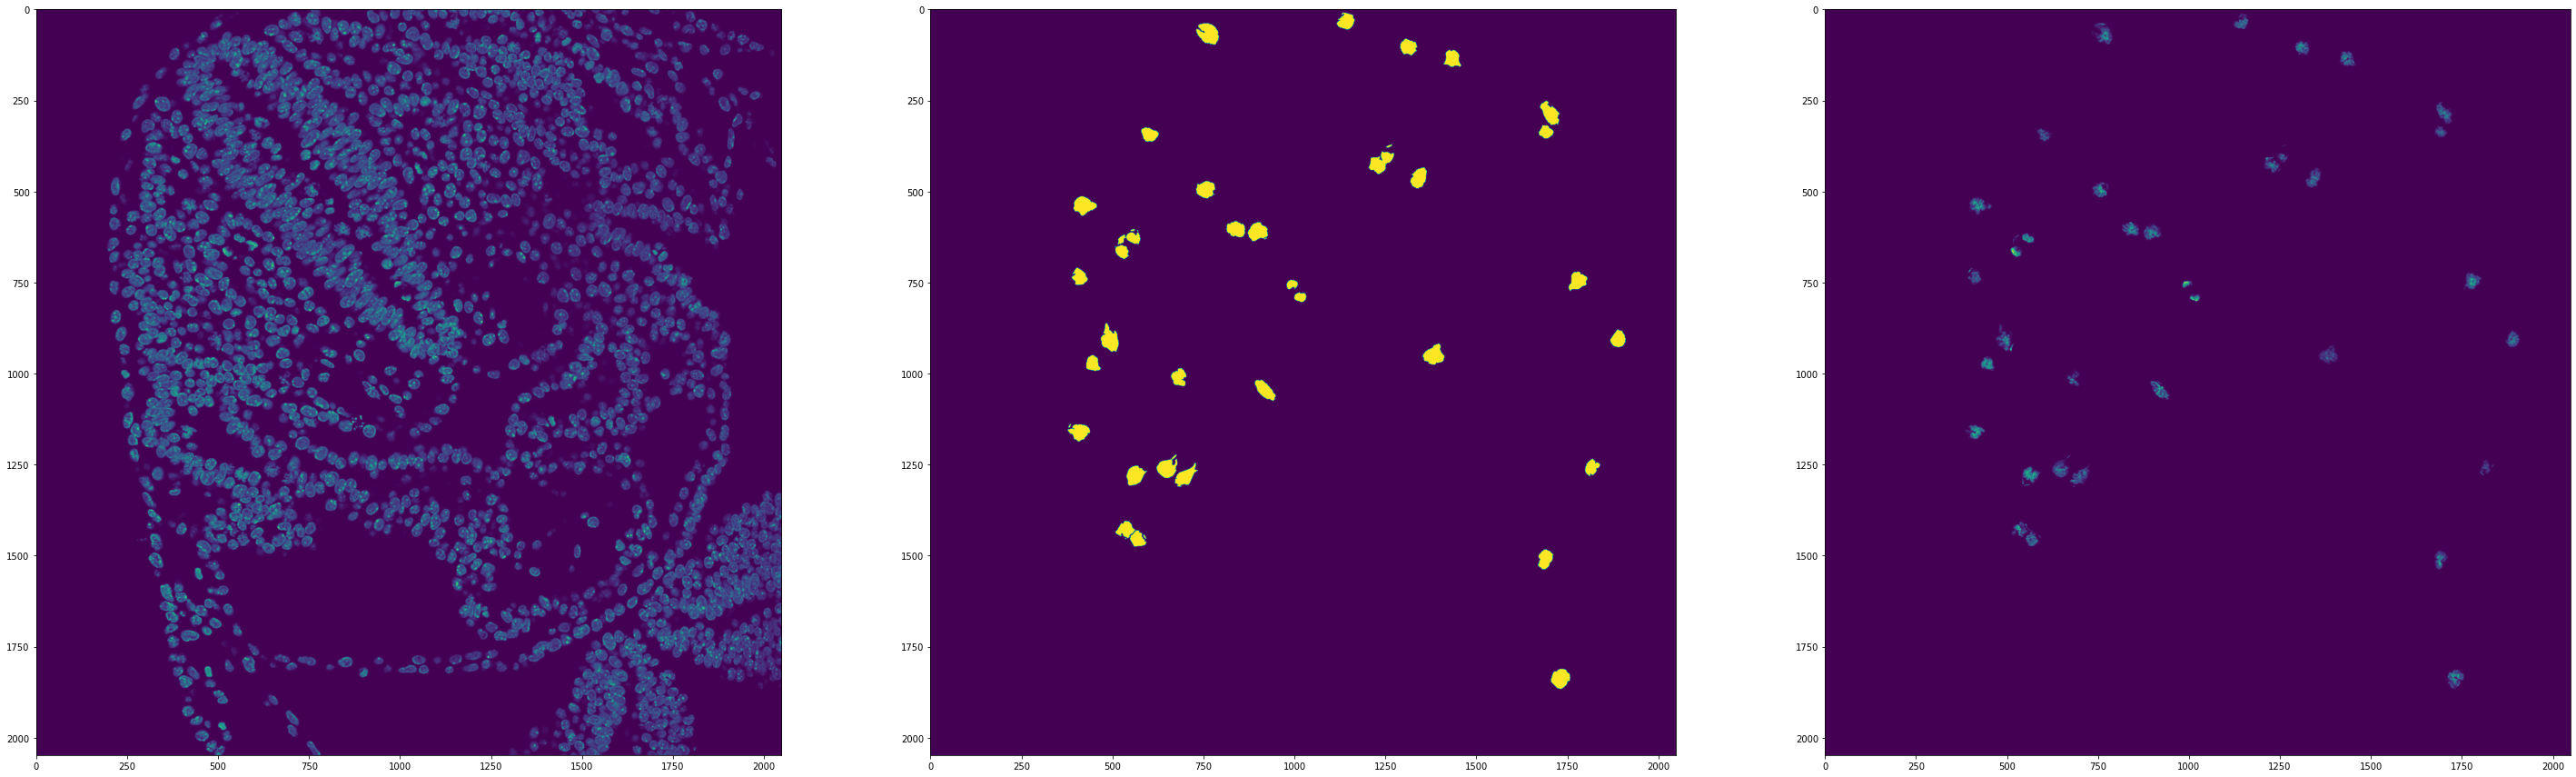

In [129]:
plt.figure(figsize=(50,50)) 
plots = [np.array(Image.open(list_raw[0])), np.array(Image.open(list_masks[0])), np.array(Image.open(list_raw[0]))*np.array(Image.open(list_masks[0]))]
for i in range(len(plots)):
    plt.subplot(1,len(plots), i+1)
    plt.imshow(plots[i])

In [82]:
#model = get_model((128,128,3), 3)
model = get_model((1024,1024,3),2)

model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [91]:
gen = Generator(list_raw, list_masks, 2, 1024)

In [85]:
image, mask = create(list_raw[0], list_masks[0], 1024)

(1024, 1024, 3)
(1024, 1024)


In [93]:
model.fit(gen, steps_per_epoch=30, epochs=1, verbose=1)

30/30 [==============================] - 249s 8s/step - loss: 0.1453 - acc: 0.9811


In [98]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 512, 512, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 512, 512, 32) 128         conv2d_55[0][0]                  
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 512, 512, 32) 0           batch_normalization_15[0][0]     
____________________________________________________________________________________________

In [92]:
#model.fit(batch_x, batch_y, verbose=1)


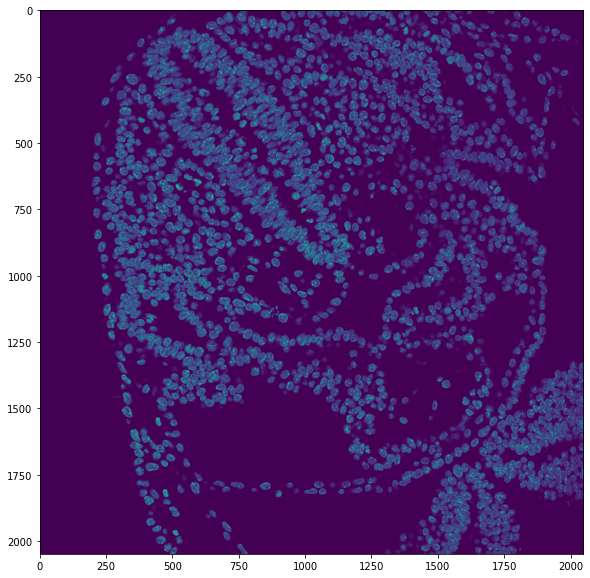

In [102]:
plt.figure(figsize=(10,10)) 
imarrayv0 = np.array(Image.open(list_raw[0]))
plt.imshow(imarrayv0)

# INFERENCE

In [6]:
file ="/Users/dvarelat/Documents/MASTER/TFM/DATA/DECON_05/DAPI/20190504_E1_DAPI_decon_0.5.nii.gz"

In [9]:
imarray = nib.load(file).get_fdata() 
imarray = imarray[:,:,:,0]
imarray.shape

(1024, 1024, 413)

In [3]:
model = load_model('model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 1024, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 512, 512, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [47]:
image = cv2.cvtColor(imarray[:,:,18].astype("uint16"), cv2.COLOR_GRAY2RGB)
image.shape

(1024, 1024, 3)

In [48]:
im = image.reshape(1,1024,1024,3)
im.shape

(1, 1024, 1024, 3)

In [49]:
res = model.predict(im)

In [57]:
print(res.shape)
print(np.unique(res[:,:,:,0]))
print(np.unique(res[:,:,:,1]))

(1, 1024, 1024, 2)
[1.]
[0.]


In [58]:
for i in range(18, 256):
    print(i)
    image = cv2.cvtColor(imarray[:,:,18].astype("uint16"), cv2.COLOR_GRAY2RGB)
    im = image.reshape(1,1024,1024,3)
    #res = model.predict(im)
    print(res.shape)
    print(np.unique(res[:,:,:,0]))
    print(np.unique(res[:,:,:,1]))
    print(".-----------")
    break

18
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
19
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
20
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
21
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
22
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
23
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
24
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
25
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
26
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
27
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
28
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
29
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
30
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
31
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
32
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
33
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
34
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
35
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
36
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
37
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
38
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
39
(1, 1024, 1024, 2)
[1.]
[0.]
.-----------
40
(1, 102

KeyboardInterrupt: 

In [42]:
x = np.sum(res, axis=3)
x.shape

(1, 1024, 1024)

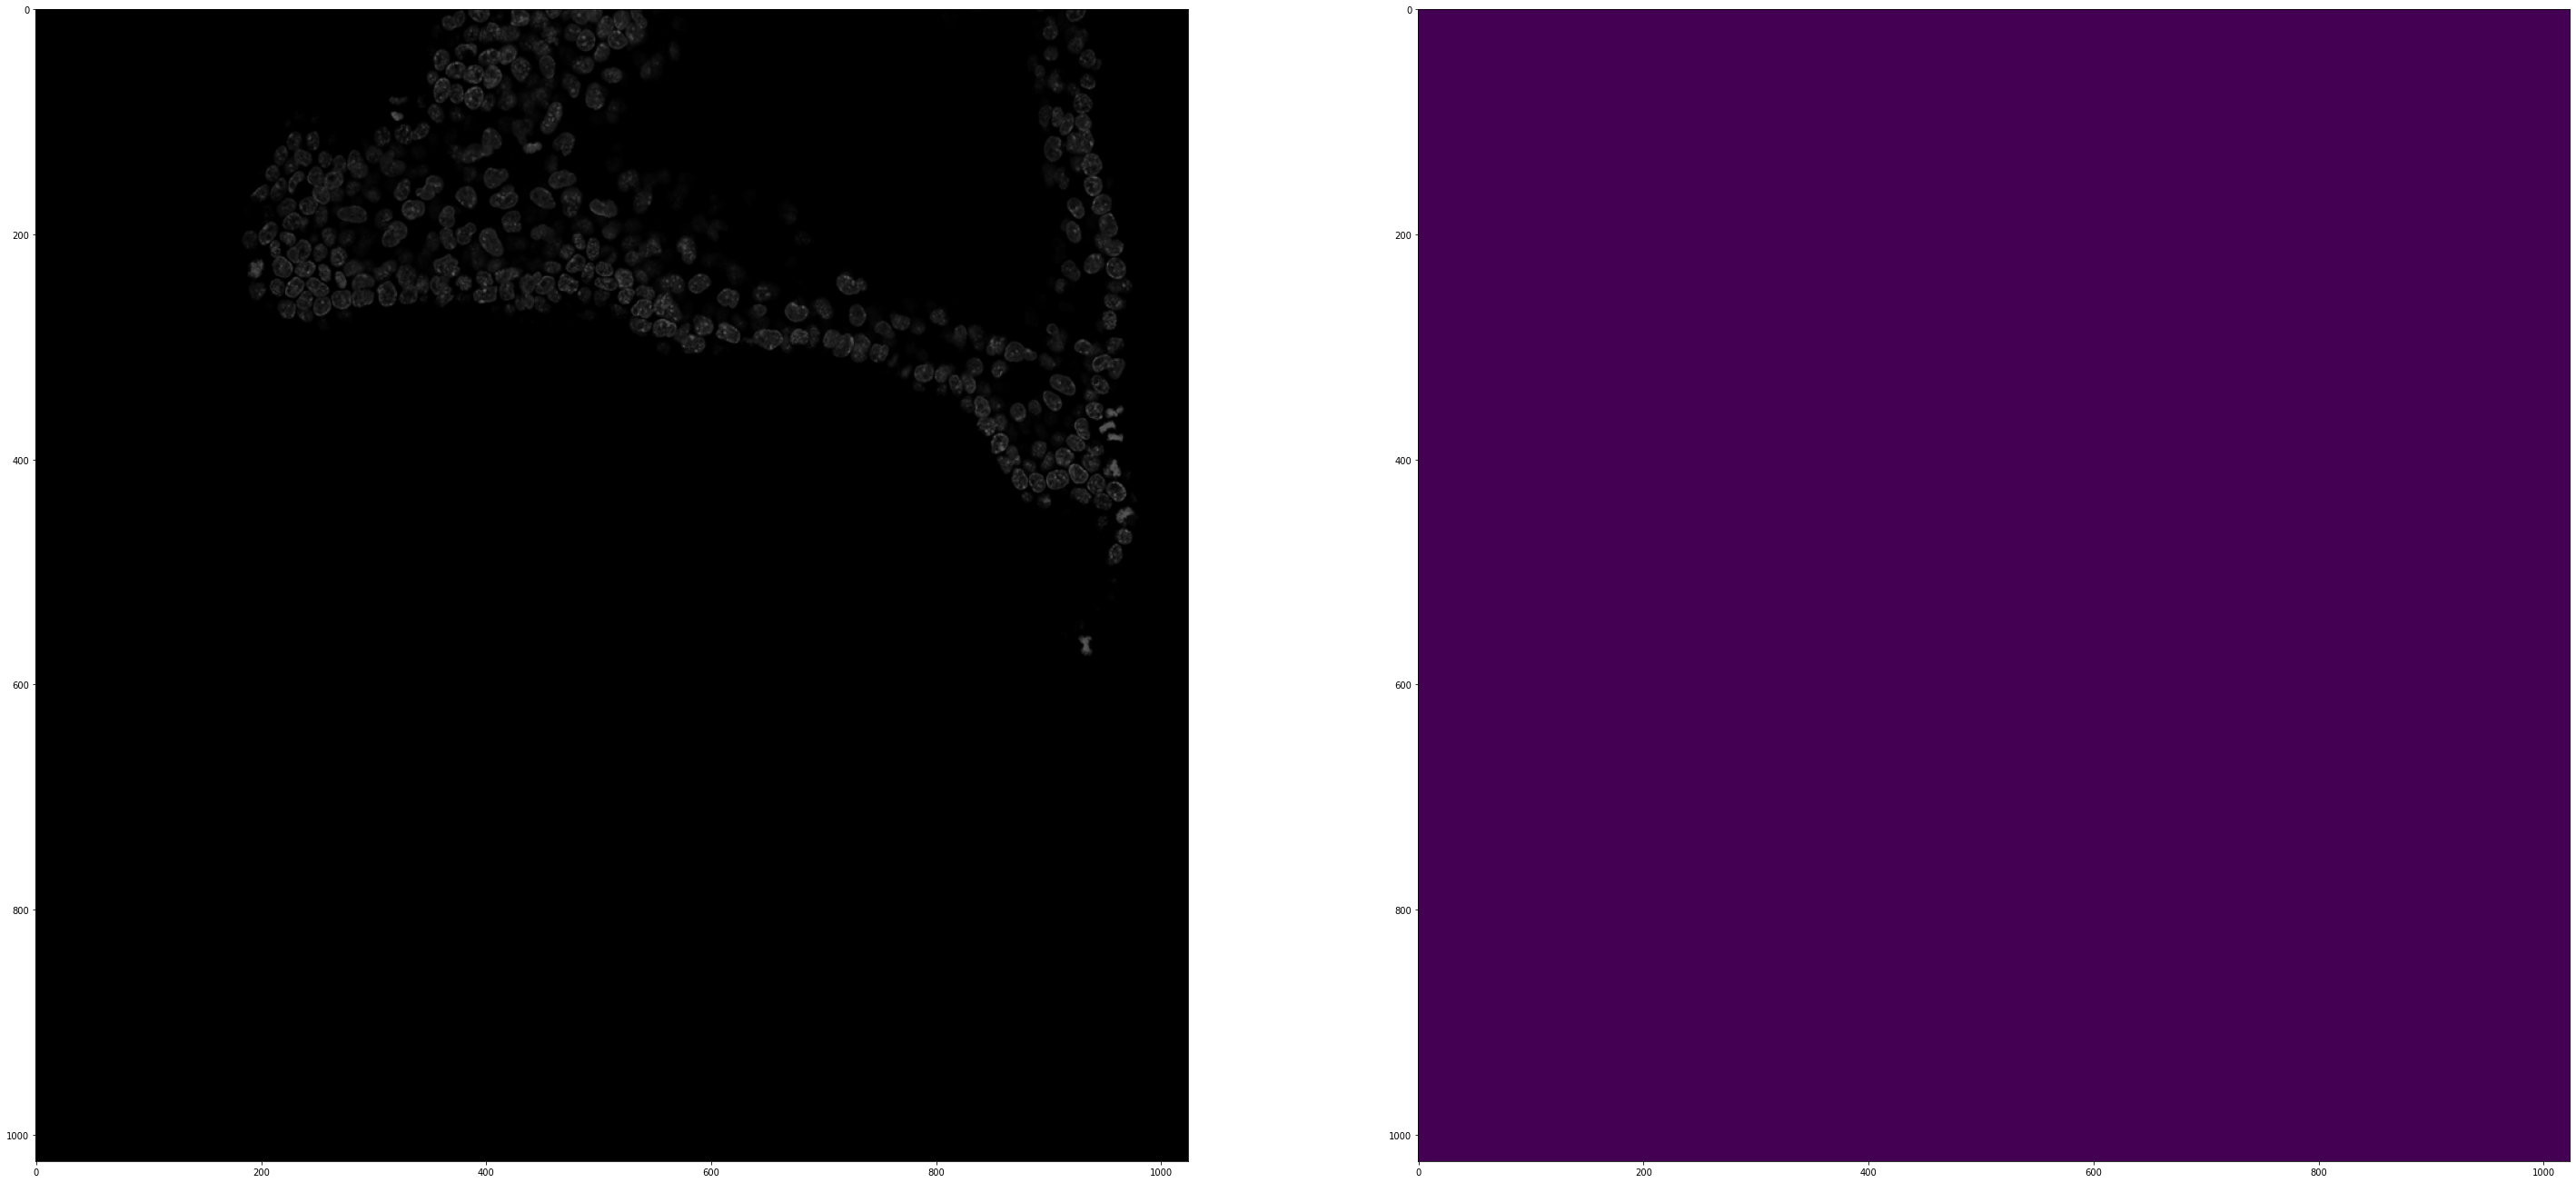

In [33]:
plt.figure(figsize=(50,50)) 
plots = [im[0,:,:,:], x[0,:,:]]
for i in range(len(plots)):
    plt.subplot(1,len(plots), i+1)
    plt.imshow(plots[i])

In [122]:
image = cv2.cvtColor(imarray[:,:,100].astype("uint16"), cv2.COLOR_GRAY2RGB)
print(image.shape)
y = model.predict(image.reshape(1,1024,1024,3))
y.shape

(1024, 1024, 3)


(1, 1024, 1024, 2)

In [123]:
yy = y[:,:,:,1].reshape((1024,1024))
yy.shape

(1024, 1024)

In [124]:
labels = (yy > 0.6).astype('float64') 
np.unique(labels)

array([0., 1.])

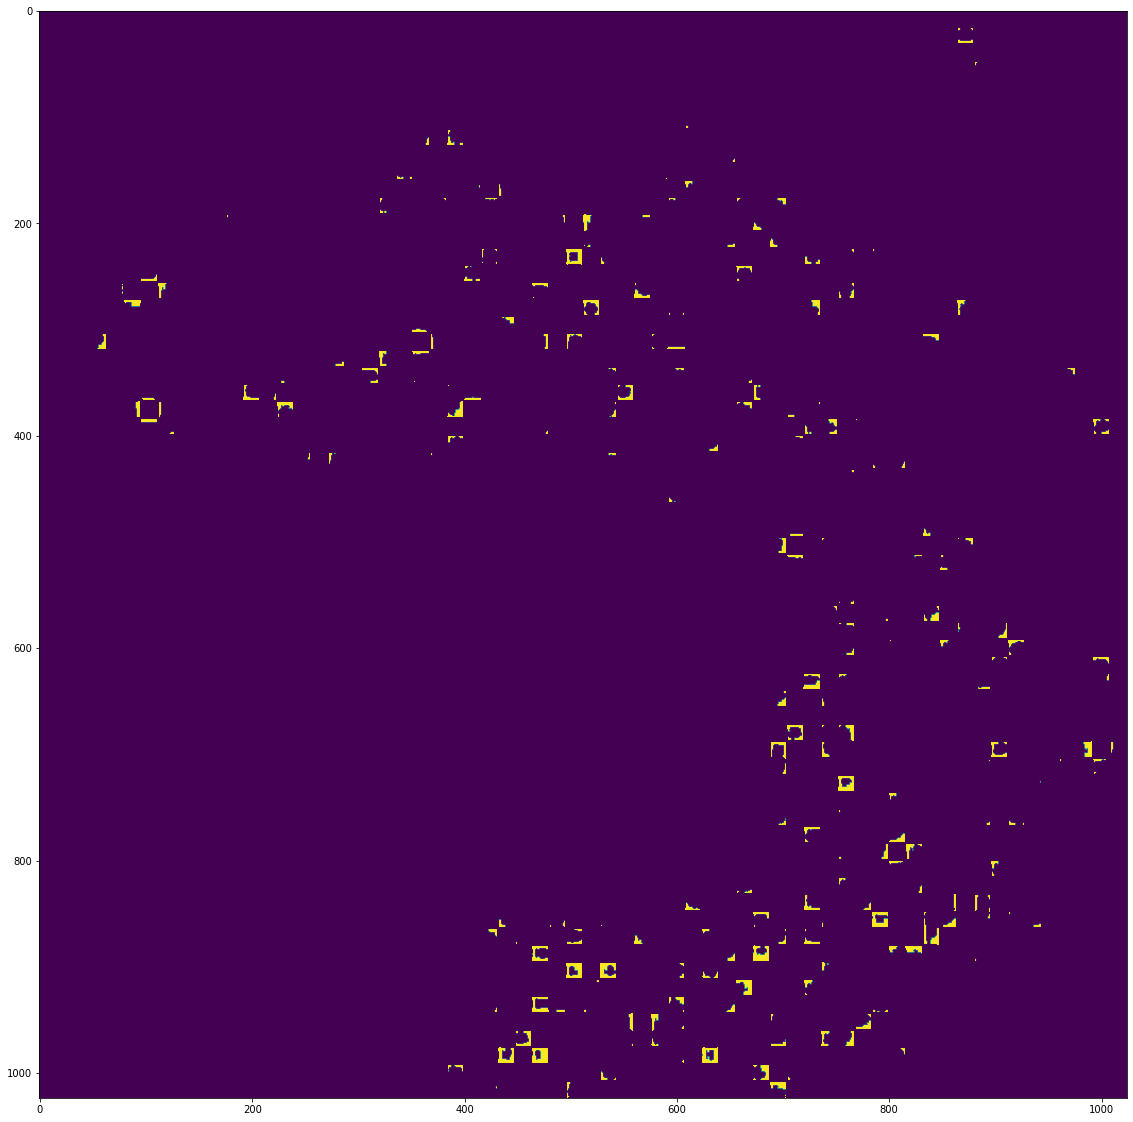

In [125]:
plt.figure(figsize=(20,20)) 

plt.imshow(labels)